### dset check
1. check pair-wise image and truth 
2. check the distribution of the dset. 

In [8]:
import glob
import numpy as np
import rasterio as rio
from rasterio.crs import CRS
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
from utils.imgShow import imsShow
from utils.transform_xy import coor2coor


In [9]:
paths_truth = sorted(glob.glob('data/dset/truth/*.tif'))
paths_scene = [path.replace('.tif', '.tif').replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.tif', '_dem.tif').replace('truth','dem') for path in paths_truth]
names_satellite = [path_truth.split('/')[-1][0:2] for path_truth in paths_truth]
print('Number of scenes:', len(paths_scene))
print('Satellite:', names_satellite[0])


Number of scenes: 65
Satellite: l5


#### 1. Check the pair-wise sence and truth images


data/dset/scene/l5_scene_01.tif


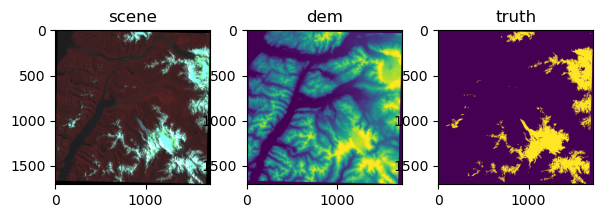

data/dset/scene/l5_scene_02.tif


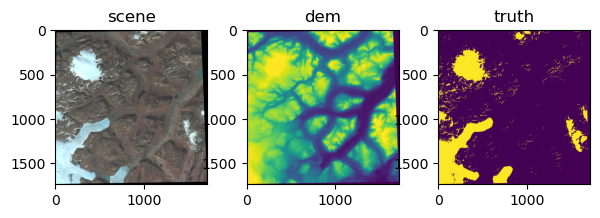

data/dset/scene/l5_scene_03.tif


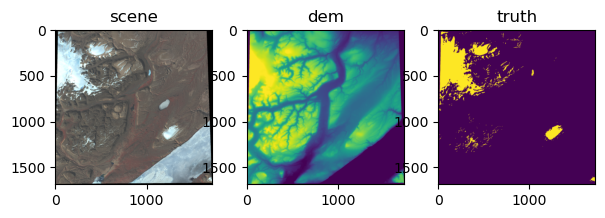

In [10]:
for id_scene in range(len(paths_scene[30:33])):
        # id_scene = 0
        print(paths_scene[id_scene])
        # print(paths_truth[id_scene])
        scene_rio = rio.open(paths_scene[id_scene])
        dem_rio = rio.open(paths_dem[id_scene])
        truth_rio = rio.open(paths_truth[id_scene])
        scene_truth_arr = [scene_rio.read([2,3,4]).transpose(1,2,0), dem_rio.read(1), truth_rio.read(1)]
        imsShow(img_list=scene_truth_arr,
                img_name_list=['scene', 'dem', 'truth'], figsize=(7,2))
        plt.show()


#### 2. check the distribution of the dataset


In [11]:
### Get center coordinates (wgs84) of the landsat scenes
centroids_wgs84 = []
for path_truth in paths_truth:
    truth_rio = rio.open(path_truth)
    bounds_truth = truth_rio.bounds
    centroid_lon, centroid_lat= (bounds_truth.left + bounds_truth.right) / 2, (bounds_truth.bottom + bounds_truth.top) / 2
    source_crs = truth_rio.crs 
    target_crs_wgs84 = CRS.from_epsg(4326)

    if source_crs != target_crs_wgs84:
        centroid_lon, centroid_lat = coor2coor(
            crs_from=source_crs,          
            crs_to=target_crs_wgs84,      
            x=centroid_lon, 
            y=centroid_lat
        )       
    centroids_wgs84.append(Point([centroid_lon, centroid_lat]))
print('number of centroids:',len(centroids_wgs84))


number of centroids: 65


In [12]:
dset_gpd = gpd.GeoDataFrame({'satellite':names_satellite}, geometry=centroids_wgs84, crs=4326)
dset_gpd.head()


,satellite,geometry
0,l5,POINT (-73.26382 -46.03553)
1,l5,POINT (-26.08861 80.77256)
2,l5,POINT (-26.53769 81.76799)
3,l5,POINT (-18.2508 64.24576)
4,l5,POINT (-81.61367 74.72153)


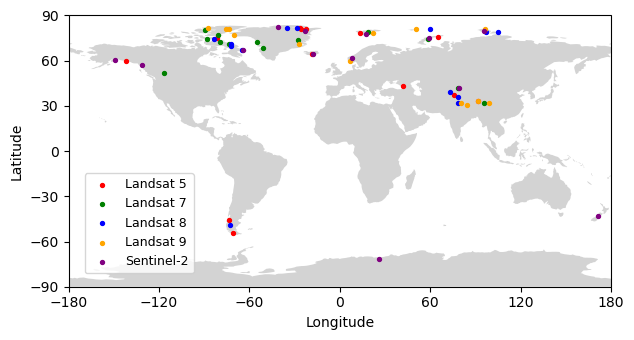

In [13]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
sat_colors = {'l5': 'red', 'l7': 'green', 'l8': 'blue', 'l9': 'orange', 's2': 'purple'}
ax.add_feature(ccrs.cartopy.feature.LAND, facecolor='lightgray')
ax.set_extent([-180, 180, -90, 90])

for sat, color in sat_colors.items():
    data_to_plot = dset_gpd[dset_gpd.satellite == sat]
    if not data_to_plot.empty:
        if sat == 's2':
            label_text = 'Sentinel-2'
        else:
            label_text = f'Landsat {sat[-1]}'           
        data_to_plot.plot(
            ax=ax, 
            marker='o', 
            markersize=8, 
            color=color, 
            label=label_text,
            aspect='equal'  
        )
ax.legend(loc=(0.03,0.05), fontsize=9)
ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.tick_params(labelsize=10)
# fig.savefig('figures/dset_distribution.png')
